In [1]:
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
# from tqdm import tqdm
from tqdm.notebook import tqdm

from monai.losses import DiceCELoss, DiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.9.1
Numpy version: 1.23.1
Pytorch version: 1.9.1+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /usr/local/lib/python3.9/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.1+cu111
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
root_dir = '/workspace/BoneMeta_all_1mm/swinunetr'
print(root_dir)

/workspace/BoneMeta_all_1mm/swinunetr


In [4]:
num_samples = 4

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-1000,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [5]:
datasets = "/workspace/JO_nb/dataset_split.json"
# datasets = "/workspace/JO_nb/mock_dataset_split.json"
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=8,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=4, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.48s/it]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=1,
    feature_size=48,
    use_checkpoint=True,
    drop_rate=0.5,
    dropout_path_rate=0.2
).to(device)

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
GPU_NUM = 1

if USE_CUDA:
    print("Using CUDA; {} devices.".format(torch.cuda.device_count()))
    GPU_NUM = torch.cuda.device_count()
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
        # augmentation_model = nn.DataParallel(augmentation_model)
    model = model.to(DEVICE)
    # augmentation_model = augmentation_model.to(DEVICE)


Using CUDA; 4 devices.


In [7]:
model

DataParallel(
  (module): SwinUNETR(
    (swinViT): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv3d(1, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
      )
      (pos_drop): Dropout(p=0.5, inplace=False)
      (layers1): ModuleList(
        (0): BasicLayer(
          (blocks): ModuleList(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=48, out_features=144, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=48, out_features=48, bias=True)
                (proj_drop): Dropout(p=0.5, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_path): Identity()
              (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
              (mlp): MLPBlock(
                (linear1): Linear(in_features=48, out_featu

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

62186659

In [9]:
model_path = "/workspace/BoneMeta_all_1mm/swinunetr/best_metric_model.pth"

if torch.cuda.device_count() > 1:
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path))

print("Loaded previous best model")

# model_path = "./model_swinvit.pt"
# weight = torch.load(model_path)

# if torch.cuda.device_count() > 1:
#     model.module.load_from(weights=weight)
# else:
#     model.load_from(weights=weight)
    
# print("Using pretrained self-supervied Swin UNETR backbone weights !")

Loaded previous best model


In [10]:
model.module.swinViT.requires_grad_(True)
# model.module.swinViT.patch_embed.requires_grad_(True)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv3d(1, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  )
  (pos_drop): Dropout(p=0.5, inplace=False)
  (layers1): ModuleList(
    (0): BasicLayer(
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=48, out_features=144, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=48, out_features=48, bias=True)
            (proj_drop): Dropout(p=0.5, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
          (mlp): MLPBlock(
            (linear1): Linear(in_features=48, out_features=192, bias=True)
            (linear2): Linear(in_features=192, out_features=48, bias=True)
            (fn): GELU()
            

In [11]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [12]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4*GPU_NUM, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 30000
eval_num = 300
post_label = AsDiscrete(threshold=0.5)
post_pred = AsDiscrete(threshold=0.5)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations+1:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Model Was Saved ! Current Best Avg. Dice: 0.4597248136997223 Current Avg. Dice: 0.4597248136997223


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4597248136997223 Current Avg. Dice: 0.455885648727417


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4597248136997223 Current Avg. Dice: 0.45827364921569824


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4597248136997223 Current Avg. Dice: 0.45956018567085266


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4597248136997223 Current Avg. Dice: 0.4558214247226715


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4597248136997223 Current Avg. Dice: 0.45962339639663696


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4597248136997223 Current Avg. Dice: 0.455715537071228


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Saved ! Current Best Avg. Dice: 0.4645528495311737 Current Avg. Dice: 0.4645528495311737


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.4663466215133667


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.45992323756217957


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.45512741804122925


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.4596395790576935


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.4574952721595764


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.4617058336734772


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.46320638060569763


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.46222686767578125


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.46335095167160034


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.4632554054260254


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.4576709270477295


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.46365487575531006


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.46093031764030457


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.46238255500793457


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.458578497171402


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.4628779888153076


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.4578474760055542


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.46336060762405396


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.45792606472969055


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.456405907869339


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.4598550498485565


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.4516385495662689


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.45945456624031067


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.45379170775413513


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.46518653631210327


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4663466215133667 Current Avg. Dice: 0.46335601806640625


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Saved ! Current Best Avg. Dice: 0.4679453670978546 Current Avg. Dice: 0.4679453670978546


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4679453670978546 Current Avg. Dice: 0.46473225951194763


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4679453670978546 Current Avg. Dice: 0.46114468574523926


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4679453670978546 Current Avg. Dice: 0.46102404594421387


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4679453670978546 Current Avg. Dice: 0.45967385172843933


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4679453670978546 Current Avg. Dice: 0.45973771810531616


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4679453670978546 Current Avg. Dice: 0.4607921540737152


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Saved ! Current Best Avg. Dice: 0.4682252109050751 Current Avg. Dice: 0.4682252109050751


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4682252109050751 Current Avg. Dice: 0.4578178822994232


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4682252109050751 Current Avg. Dice: 0.46256959438323975


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.47176387906074524


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.45908594131469727


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.4590006172657013


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.468138724565506


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.4650260806083679


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.46310412883758545


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.4696322977542877


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.46649789810180664


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.46571001410484314


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.4614063799381256


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.4590366780757904


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.46764102578163147


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.4567582905292511


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.46289438009262085


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.4612549841403961


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.4578348398208618


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.465195894241333


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.46335622668266296


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.45774078369140625


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.4651212990283966


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.46122023463249207


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.46300196647644043


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.4639706313610077


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.471151202917099


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.46465256810188293


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.4618280827999115


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.47176387906074524 Current Avg. Dice: 0.4680507779121399


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4618719816207886


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4593782126903534


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.45658063888549805


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.467736154794693


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4671478867530823


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.45676782727241516


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4643978178501129


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.45648112893104553


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.45631369948387146


<All keys matched successfully>

In [13]:
while global_step < 120001:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.46759429574012756


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4630812406539917


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4716251492500305


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.46376681327819824


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4615817070007324


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.46530967950820923


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.46707218885421753


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.46221113204956055


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4550425410270691


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4609402120113373


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4595339000225067


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4600650370121002


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.45608288049697876


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4616892635822296


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.45955678820610046


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.45700496435165405


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4601565897464752


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4661847651004791


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.45280054211616516


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.46722903847694397


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4592994749546051


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.46722227334976196


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.46102818846702576


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Validate (X / X Steps) (dice=X.X):   0%|                                                               | 0/35 …

Model Was Not Saved ! Current Best Avg. Dice: 0.4737700819969177 Current Avg. Dice: 0.4637935161590576


Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

Training (X / X Steps) (loss=X.X):   0%|                                                               | 0/60 …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [14]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.4738 at iteration: 23700


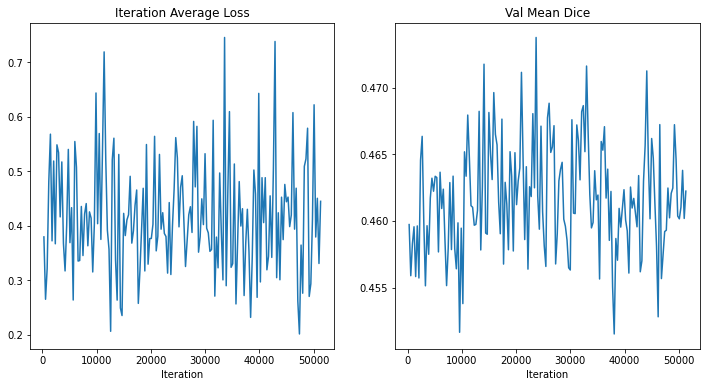

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
case_num = 4
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = 'sample'
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    if isinstance(img, np.ndarray) or isinstance(label, np.ndarray):
        img = torch.from_numpy(img)
        label = torch.from_numpy(label)
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]]
    )
    plt.show()

In [ ]:
next(iter(train_loader))

In [ ]:
sample = next(iter(train_loader))
sample_image = sample["image"] 
sample_label = sample["label"]

sample_pred = model(sample_image)


In [ ]:
from monai.losses import DiceCELoss, DiceLoss
loss_function1 = DiceCELoss(include_background=False, to_onehot_y=False, softmax=True)
loss_function2 = DiceLoss(include_background=False, to_onehot_y=False, softmax=True)

In [ ]:
sample_image.shape

In [ ]:
import matplotlib.pyplot as plt

def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)


#npy image, npy label 
def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
  plt.show()
    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

In [ ]:
def plot_img_label_pred(image_npy, label_npy, pred_npy, interval = 5, offset = 0, end=None, figsize_per_image = 5, show_only_positive = False):
    sliced_img = slice_img(image_npy, offset, end, interval)
    sliced_label = slice_img(label_npy, offset, end, interval)
    sliced_pred = slice_img(pred_npy, offset, end, interval)

    if show_only_positive:
        positive_idx = (sliced_label + sliced_pred).sum(axis = (1,2)) > 0.5
        sliced_img = sliced_img[positive_idx]
        sliced_label = sliced_label[positive_idx]
        sliced_pred = sliced_pred[positive_idx]
    
    num_row = len(sliced_img)
    num_col = 3
    
    plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

    for i in range(0, num_row):
        plt.subplot(num_row, num_col, i*num_col+1)
        tissue_image = sliced_img[i]
        plt.imshow(tissue_image, 'gray')

        plt.subplot(num_row, num_col, i*num_col+2)
        mask = sliced_label[i]
        label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
        plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')
        
        plt.subplot(num_row, num_col, i*num_col+3)
        mask = sliced_pred[i]
        pred_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(255,0,0))
        plt.imshow(sitk.GetArrayFromImage(pred_on_tissue), 'gray')

    plt.tight_layout()
    plt.show()

In [ ]:
sample_image[0].shape

In [ ]:
import SimpleITK as sitk

In [ ]:
sample_label.dtype

In [ ]:
sample_pred.min()

In [ ]:
pred_result = (sample_pred > 0).cpu().to(torch.uint8)

In [ ]:
sample_num = 5
plot_img_label_pred(sample_image[sample_num].cpu(), sample_label[sample_num].cpu().to(torch.uint8), pred_result[sample_num], show_only_positive = True, interval =2)

In [ ]:
loss_function1(sample_pred.cpu(), sample_label.cpu())

In [ ]:
from monai.losses import DiceCELoss, DiceLoss
loss_function1 = DiceCELoss(include_background=False, to_onehot_y=False, softmax=True)
loss_function2 = DiceLoss(include_background=False, to_onehot_y=False, softmax=True)
loss_function3 = DiceLoss(include_background=False, to_onehot_y=True, softmax=True)

#### for i in range(len(sample_pred)):
    print(loss_function3(sample_pred[i].cpu(), sample_label[i].cpu()))
    

In [ ]:
loss_function2(sample_pred[:6].cpu(), sample_label[:6].cpu())

#### sample_pred.shape